In [1]:
import zipfile

import sys
import os

# Subir un nivel al path
sys.path.append(os.path.abspath(".."))
from redes import FaceClassifierNN, FaceClassifier2NN

with zipfile.ZipFile('../Test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from skimage.feature import hog
import xgboost as xgb
from sklearn.metrics import accuracy_score
import torch

In [3]:
suffix = '.pgm'
kaggle_files = os.listdir('Test')
pgm_kaggle_files = [filename for filename in kaggle_files if filename.endswith(suffix)]

In [5]:
len(pgm_kaggle_files)

8000

In [4]:

def imgs_to_hog(imgs):
    hog_features_test = []
    for img in tqdm(imgs, desc='Extrayendo HOG features'):
        fd = hog(img, visualize=False)
        hog_features_test.append(fd)

        #transformamos en array y stackeamos
    ret_array = np.array(hog_features_test)
    ret_array = np.vstack(hog_features_test)

    return ret_array

In [5]:
kaggle_patches = []
for filename in tqdm(pgm_kaggle_files):
  path = 'Test/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  kaggle_patches.append(image)

100%|██████████| 8000/8000 [01:17<00:00, 103.85it/s]


In [6]:
pgm_kaggle_files_id = []

for filename in tqdm(pgm_kaggle_files):
  pgm_kaggle_files_id.append(filename[5:-4])

100%|██████████| 8000/8000 [00:00<00:00, 2342532.25it/s]


Para cargar modelo ML

In [ ]:
# Aquí debe utilizar su modelo 
model = joblib.load('../modelos/nueva_prueba_LR.pkl') 

Para cargar Red

In [22]:
modelo = FaceClassifier2NN(input_dim=447)
modelo.load_state_dict(torch.load('../modelos/nn_20250701_v2.pth'))   

<All keys matched successfully>

In [23]:
modelo.eval()

FaceClassifier2NN(
  (network): Sequential(
    (0): Linear(in_features=447, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [39]:
# Aquí debe procesar las imagenes de pgm_kaggle_files
# Descomentar si se importa PCA por separado

#scaler = joblib.load('../modelos/scaler_20250701.pkl') 
pca_model = joblib.load('../modelos/pca_20250701_v2.pkl') 

pgm_kaggle_array = np.stack(kaggle_patches)
pgm_kaggle_array = pgm_kaggle_array / 255.0  # Normalizar las imágenes
pgm_kaggle_array = imgs_to_hog(pgm_kaggle_array)  # Extraer características HOG
kaggle_images_flatten = np.array([im.flatten() for im in tqdm(pgm_kaggle_array, desc='Construyendo X')])

# Descomentar si se importa PCA por separado
X_pca_kag = pca_model.transform(kaggle_images_flatten)
#X_pca_kag = pca_model.transform(scaler.transform(kaggle_images_flatten))


Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 106326.90it/s]


In [10]:
X_pca_kag = kaggle_images_flatten

In [25]:
X_pca_kag.shape

(8000, 447)

Prediccion con modelo de ML

In [40]:
# Predicción
y_kag = model.predict(X_pca_kag)

Prediccion con Red Neuronal

In [26]:
X_unlabeled_tensor = torch.tensor(X_pca_kag, dtype=torch.float32)

In [27]:
with torch.no_grad():
    logits = modelo(X_unlabeled_tensor).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int()

In [28]:
y_kag = preds.numpy()

In [41]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [42]:
kaggle_hat.head()

,id,target_feature
0,0,0
1,1,0
1112,2,0
2223,3,0
3334,4,0


In [43]:
kaggle_hat.value_counts('target_feature')

target_feature
0    7583
1     417
Name: count, dtype: int64

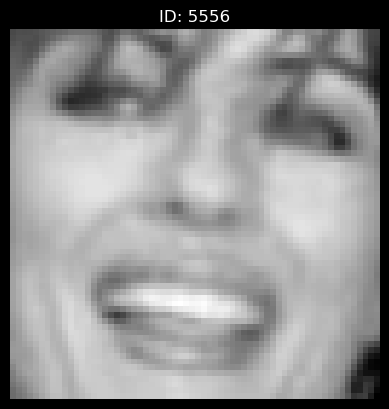

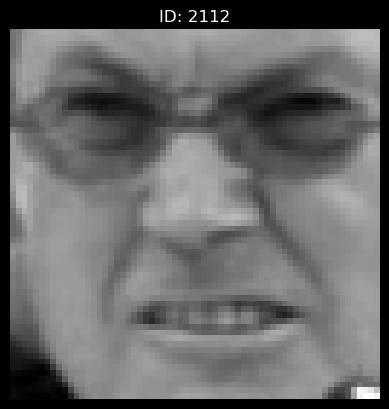

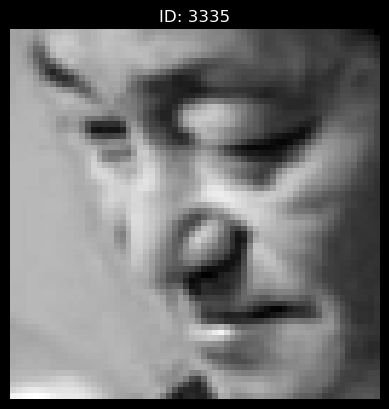

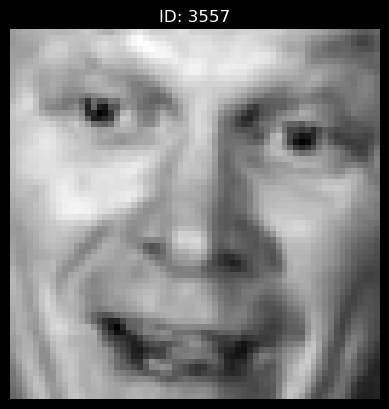

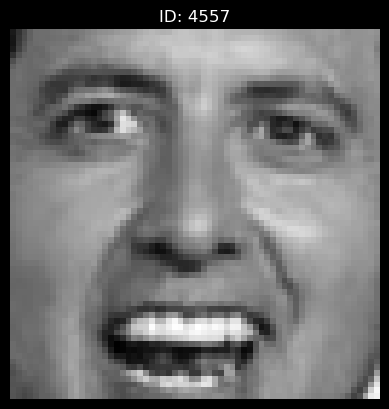

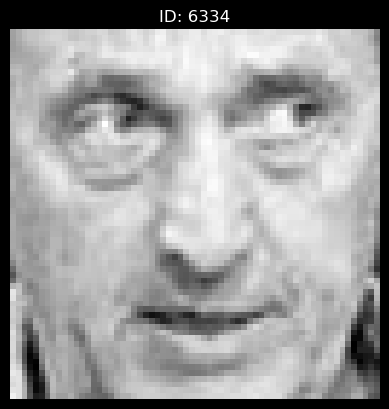

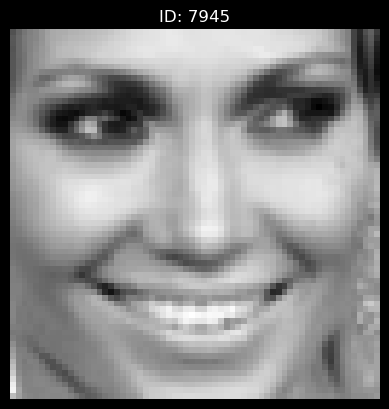

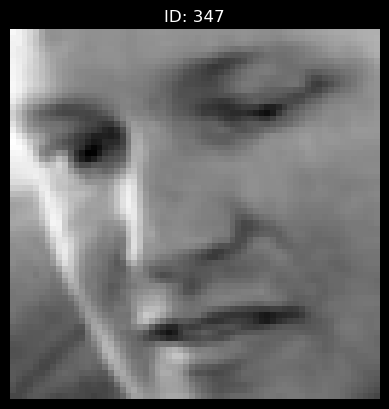

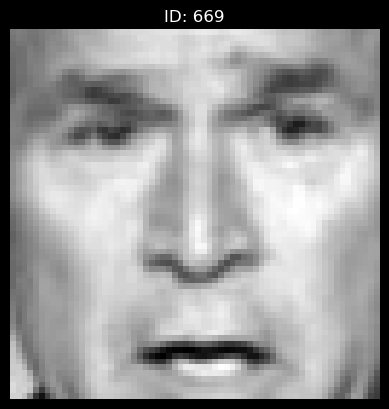

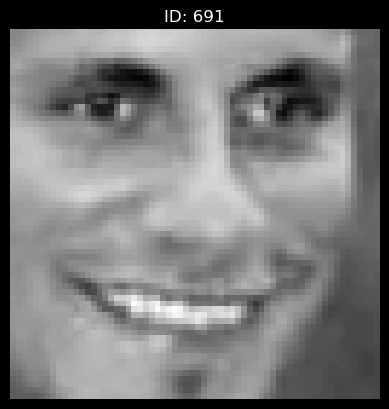

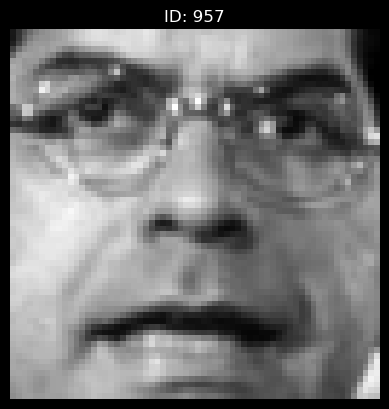

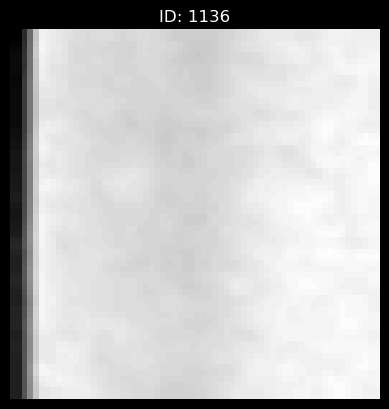

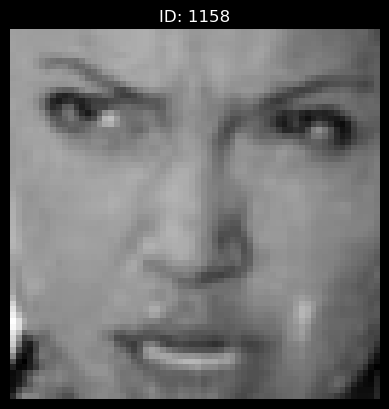

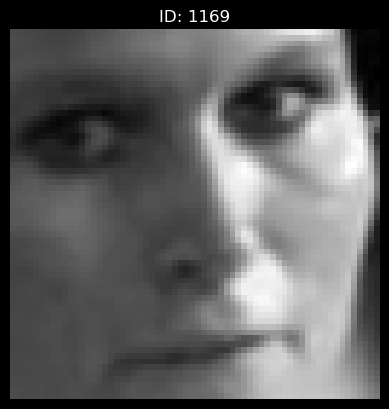

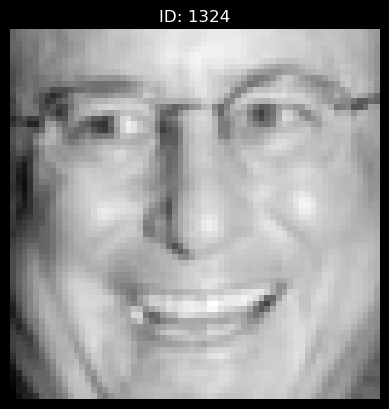

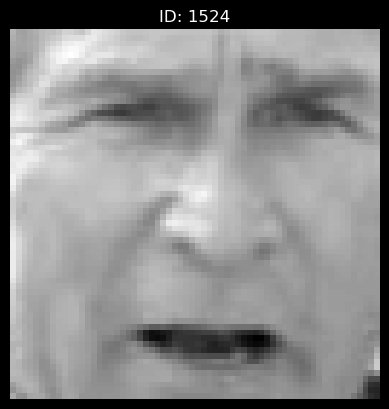

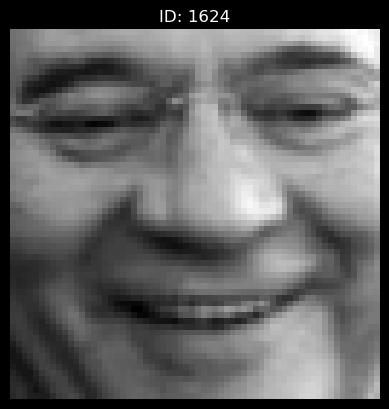

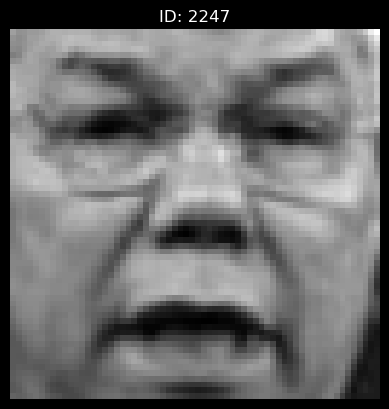

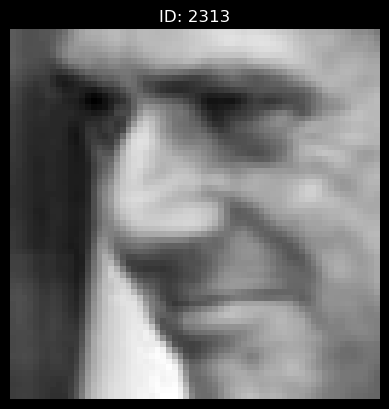

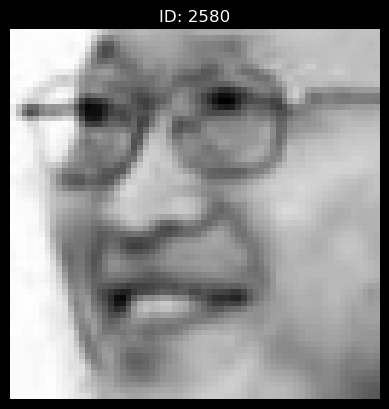

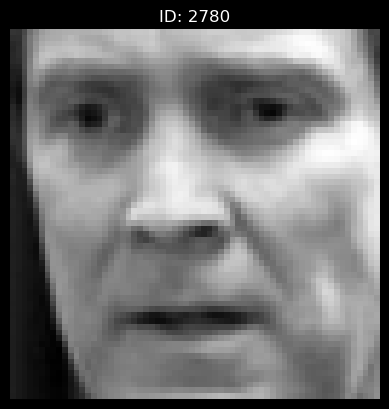

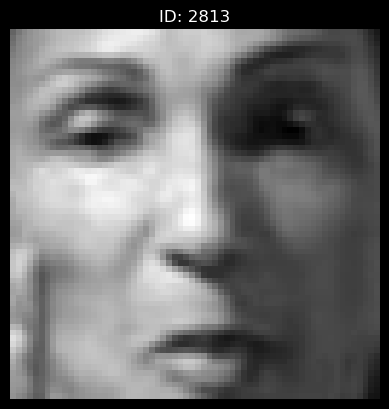

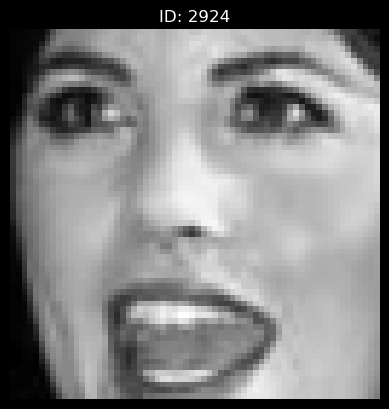

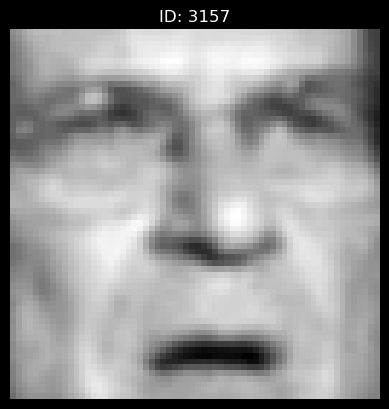

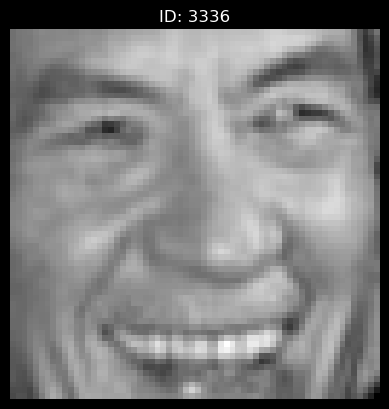

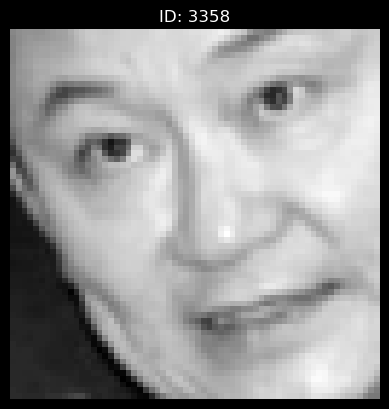

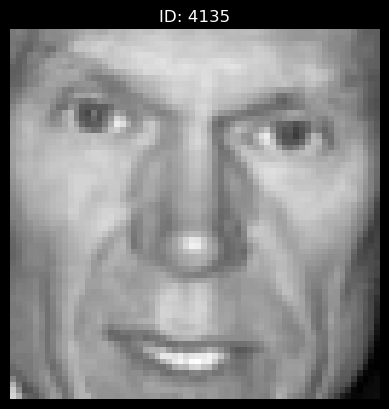

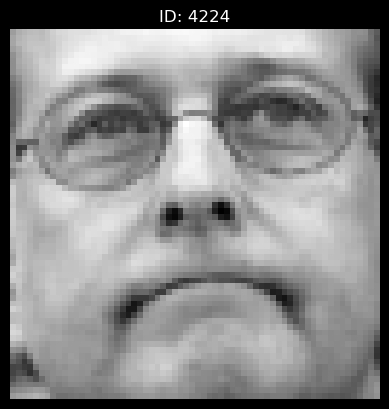

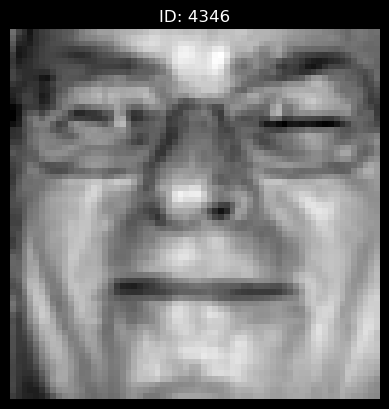

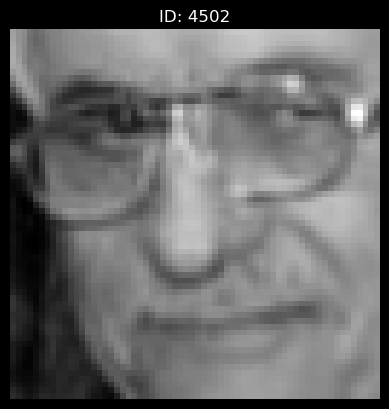

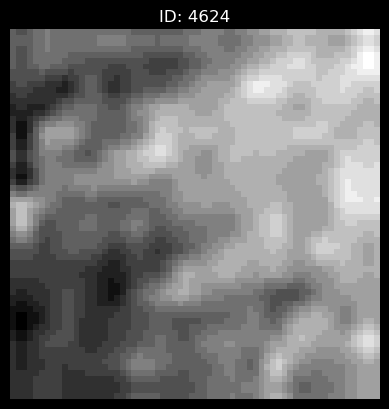

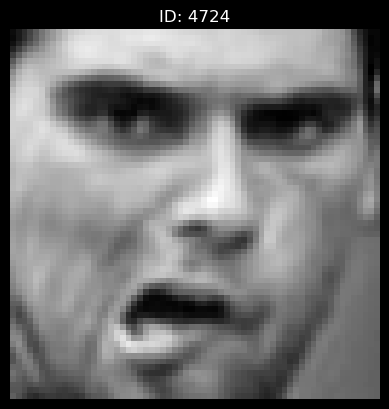

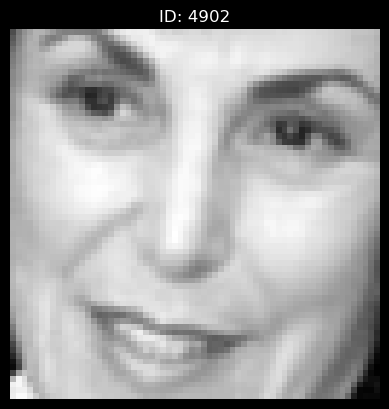

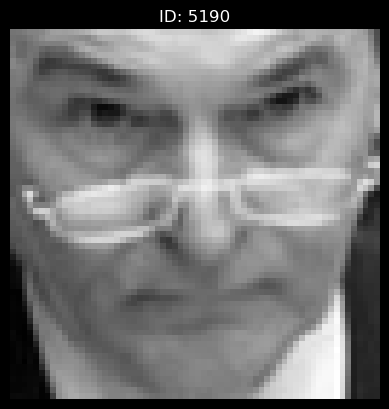

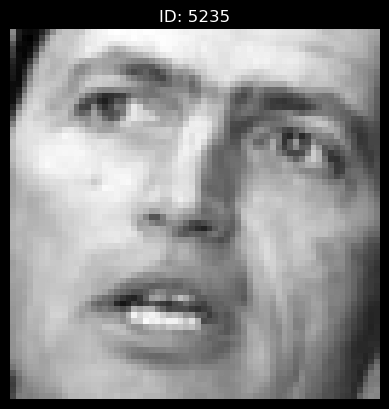

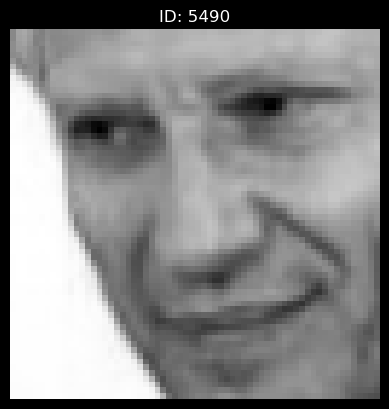

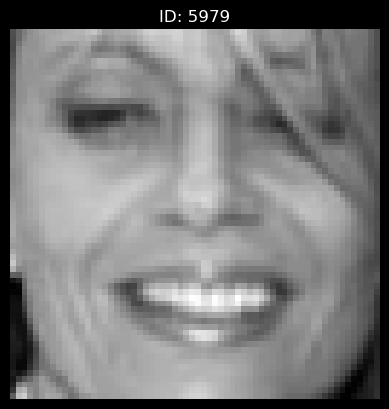

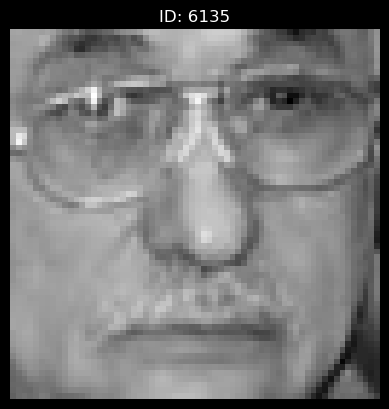

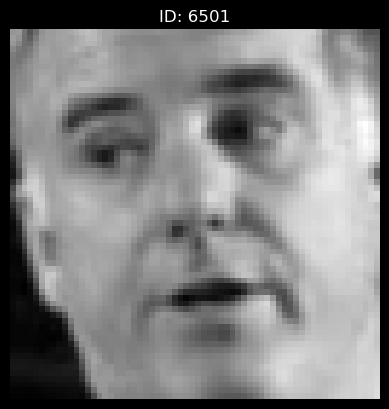

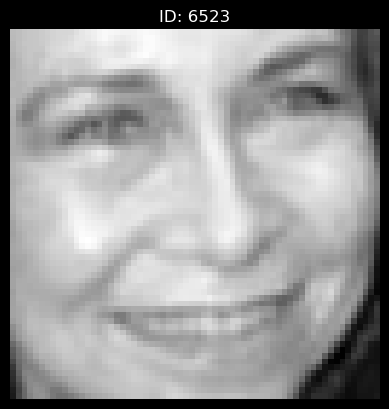

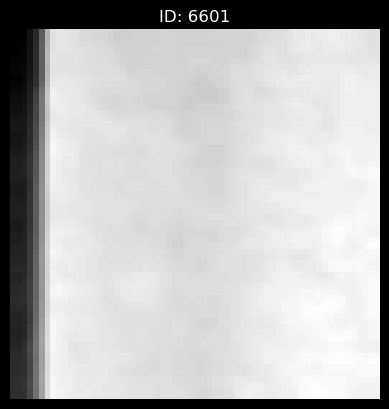

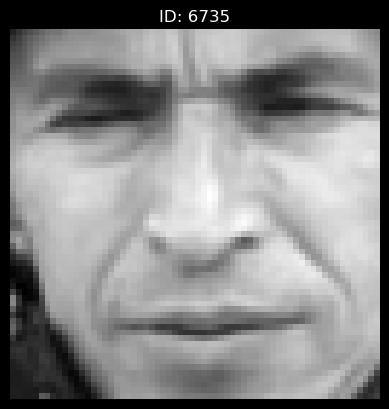

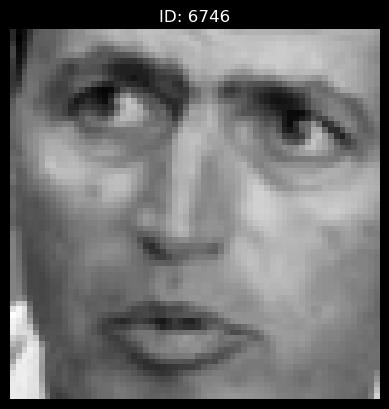

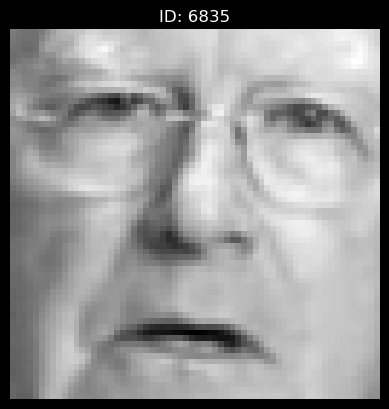

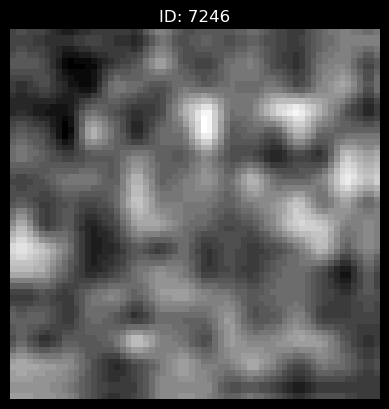

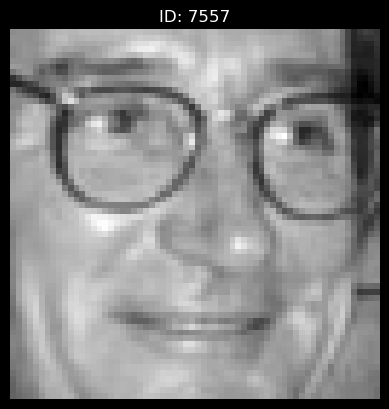

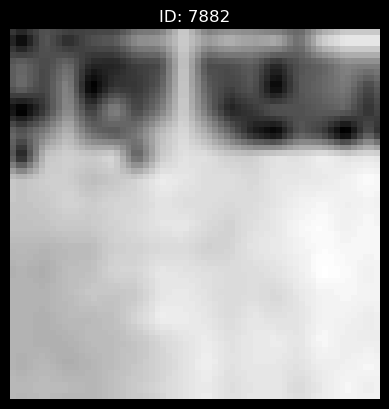

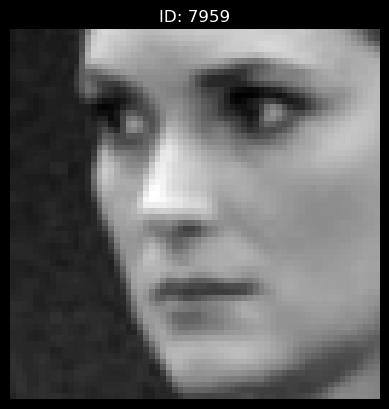

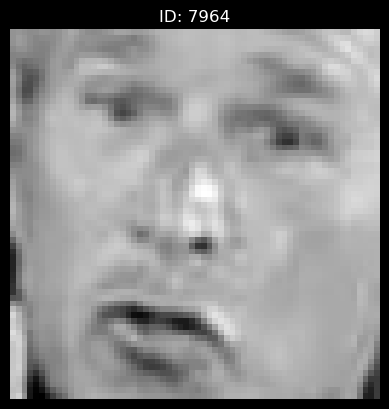

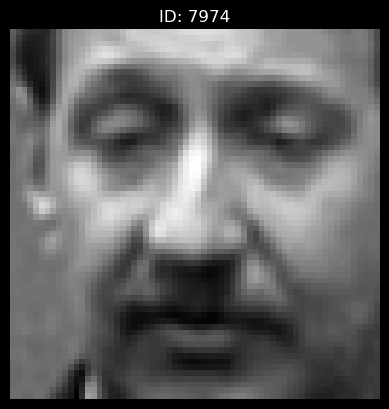

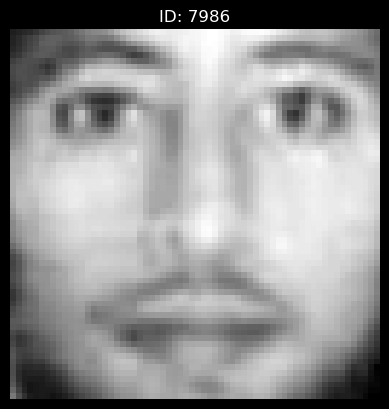

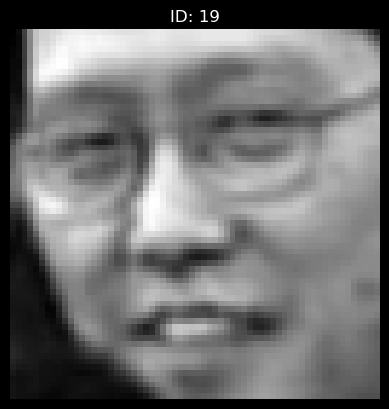

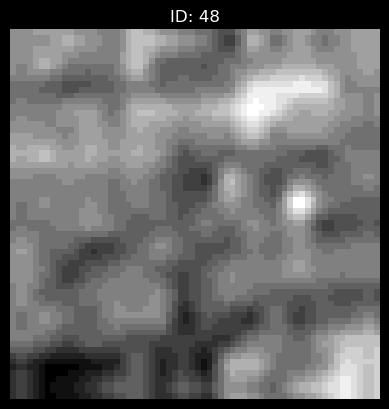

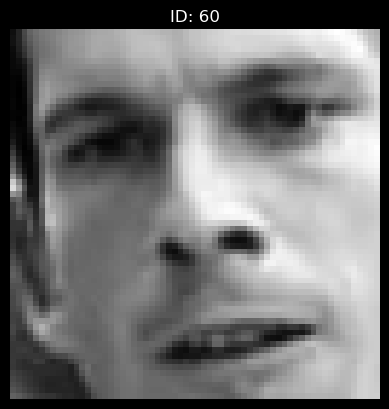

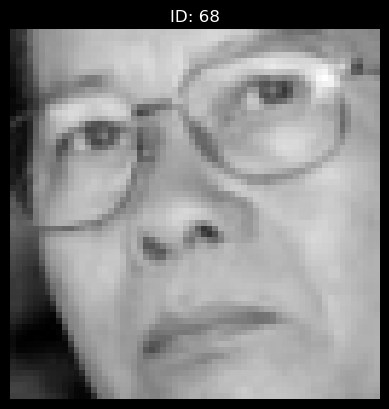

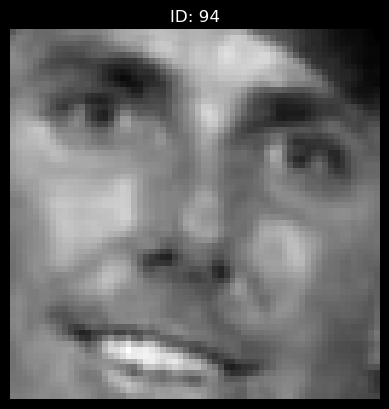

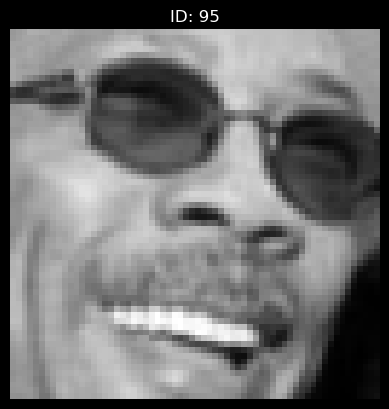

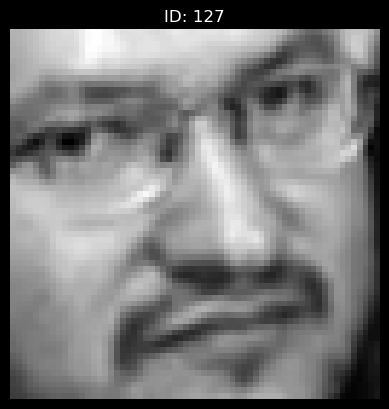

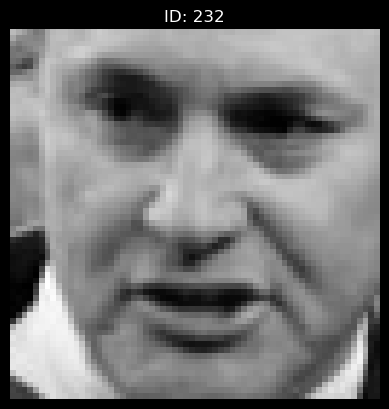

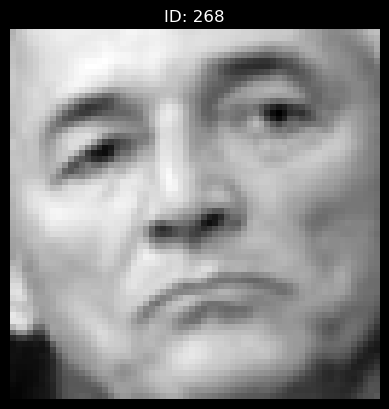

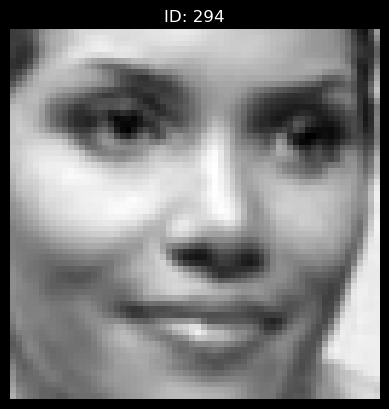

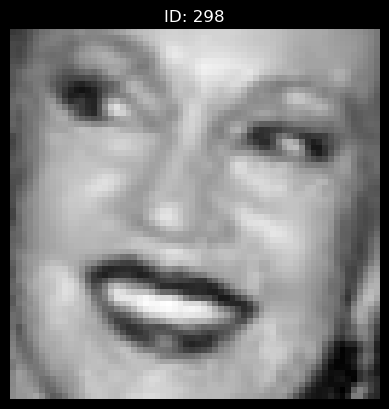

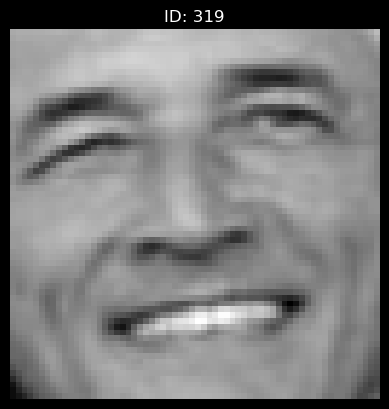

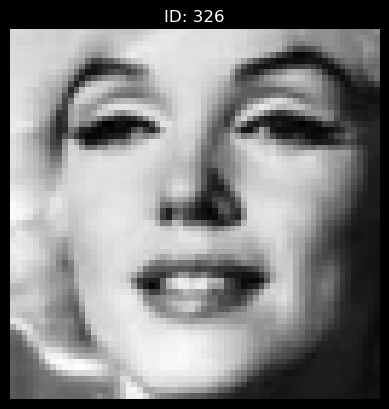

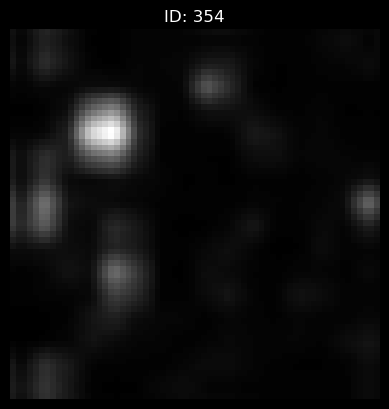

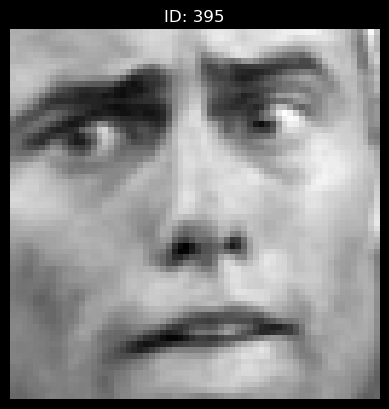

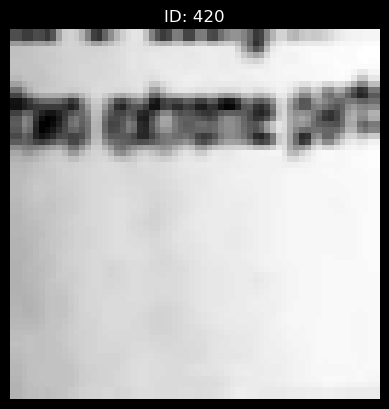

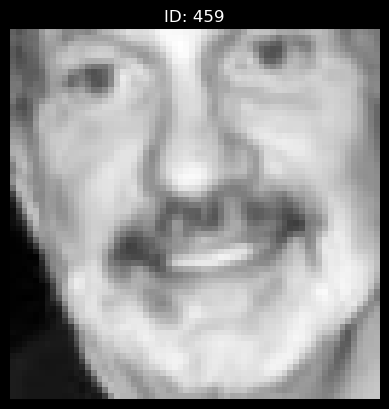

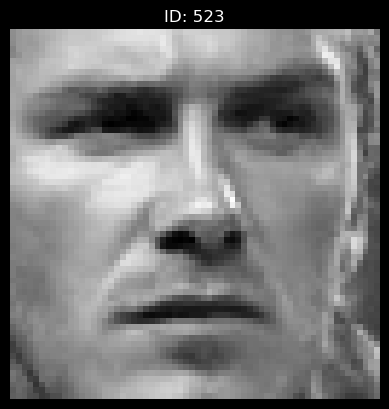

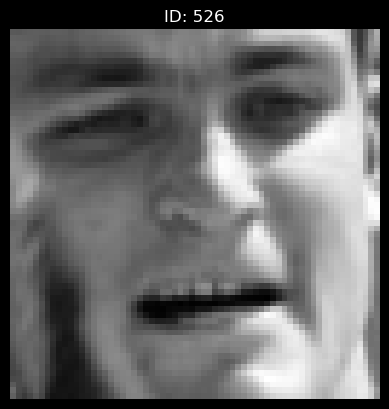

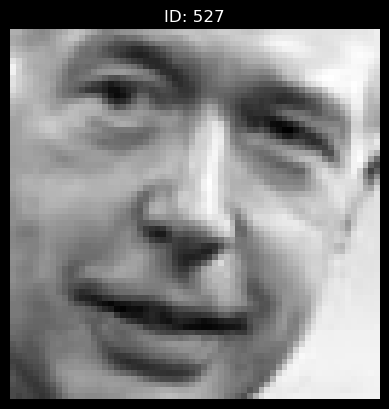

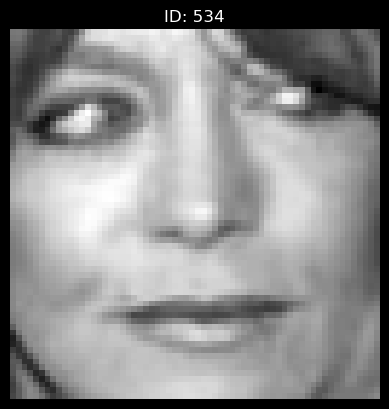

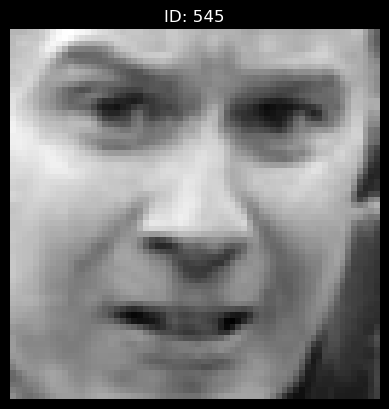

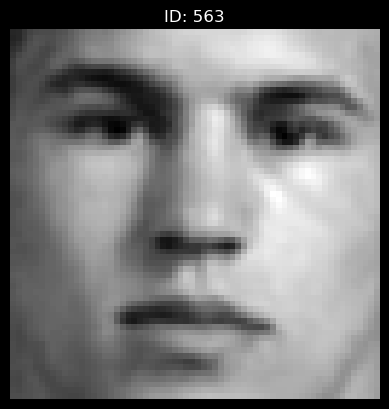

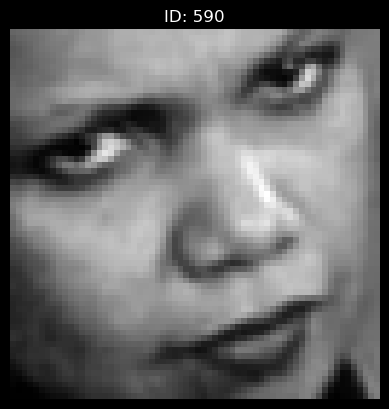

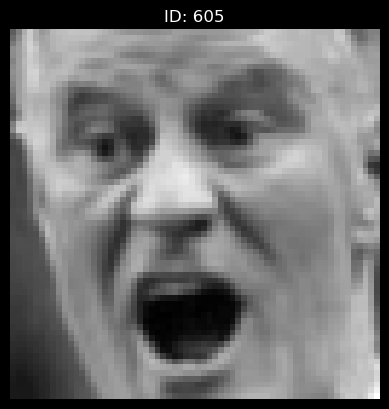

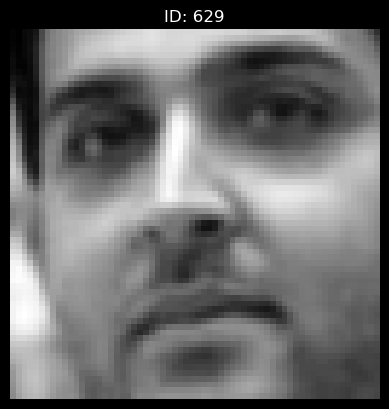

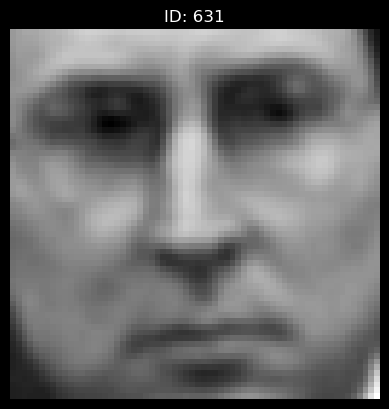

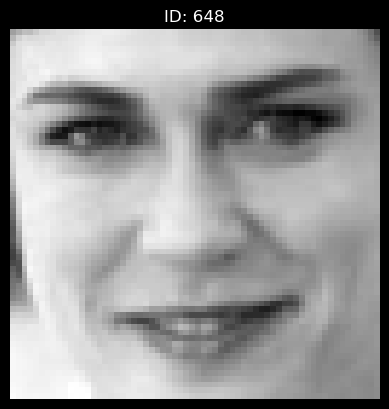

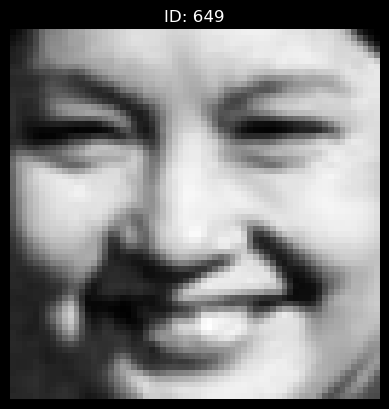

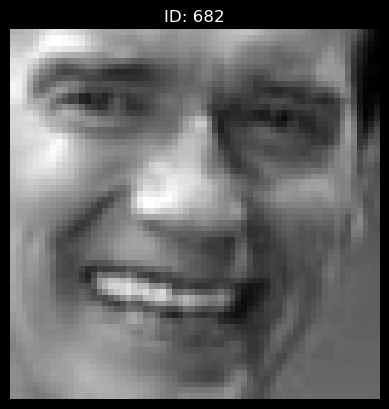

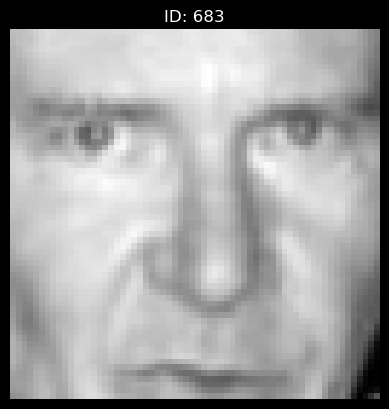

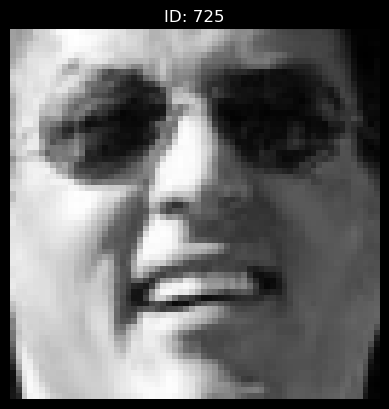

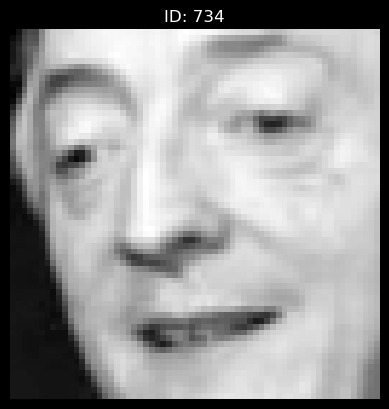

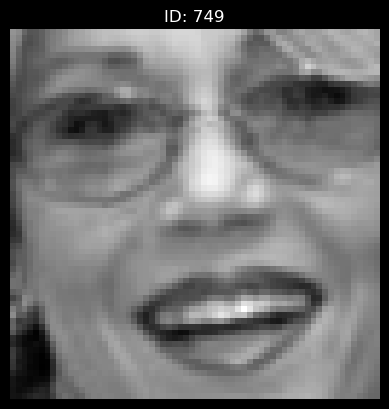

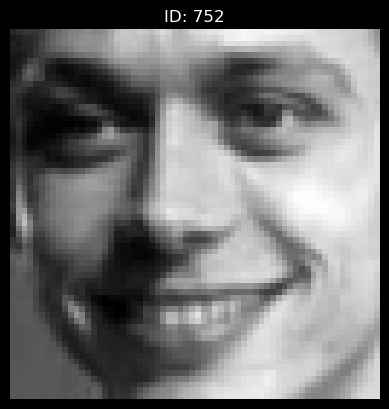

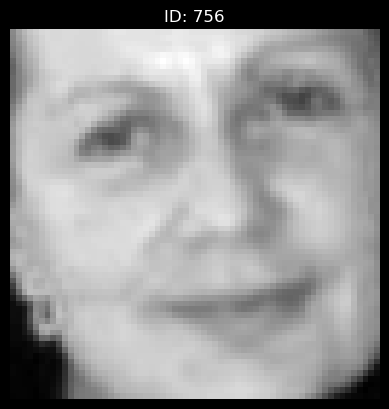

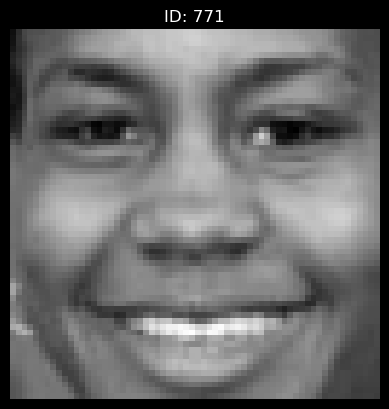

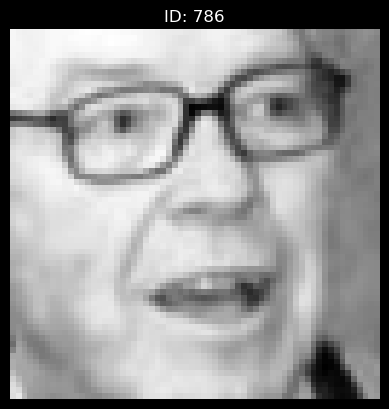

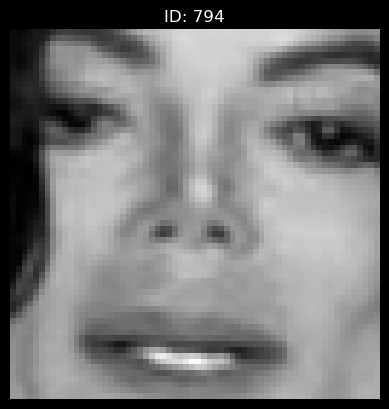

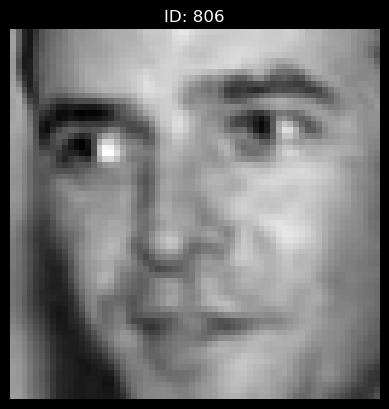

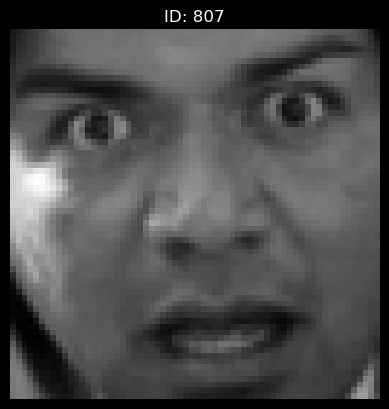

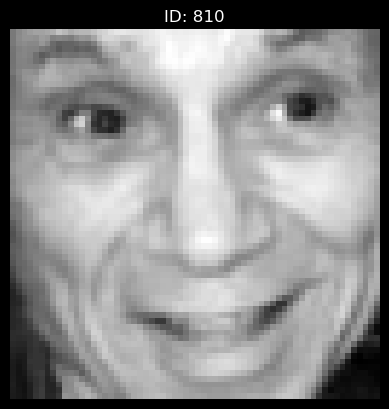

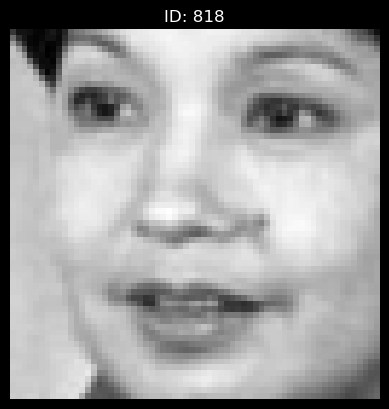

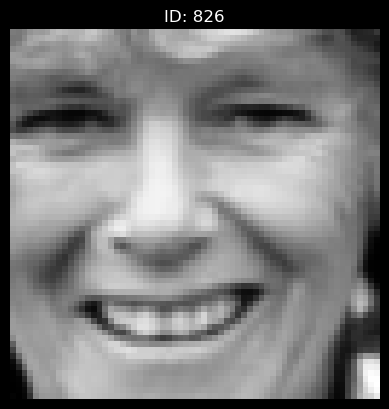

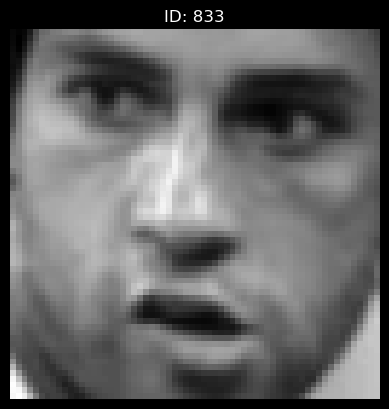

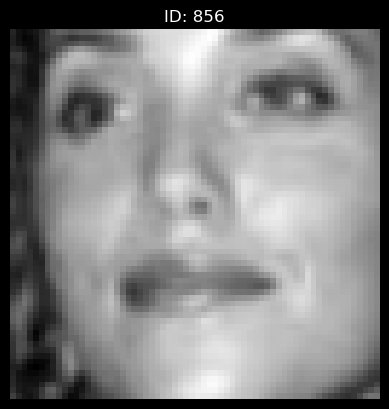

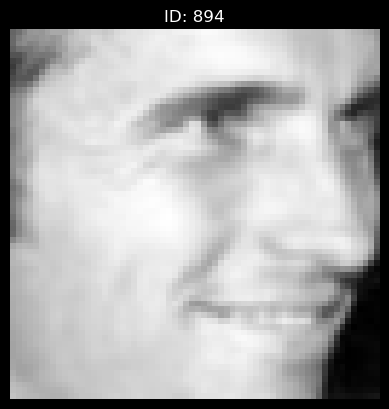

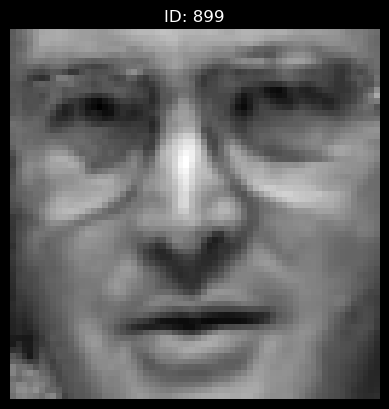

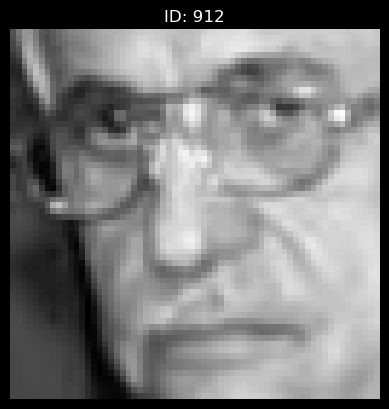

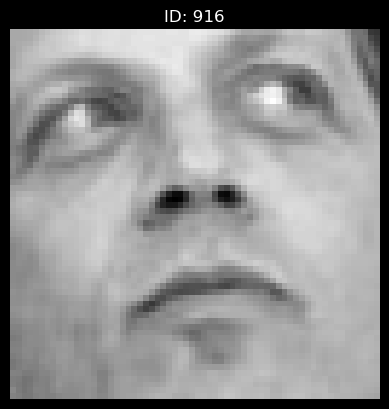

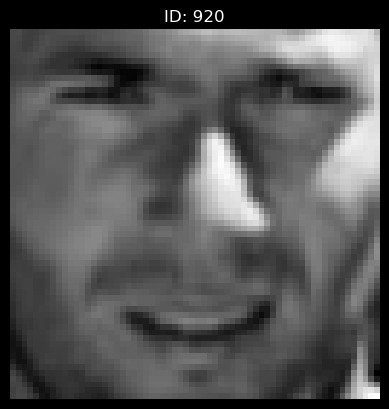

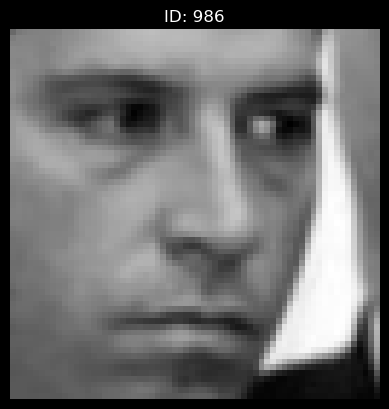

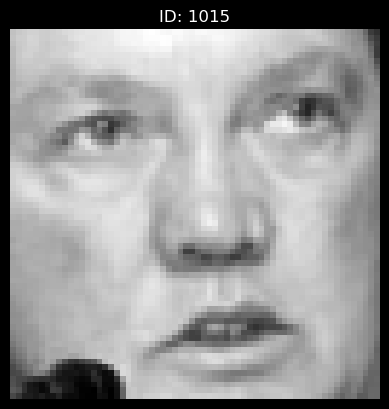

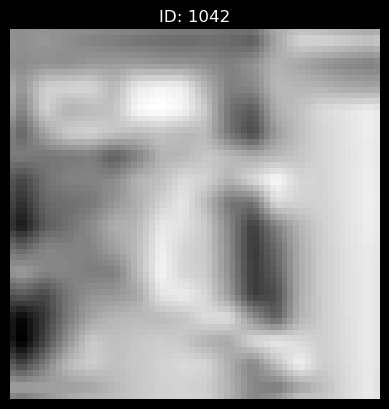

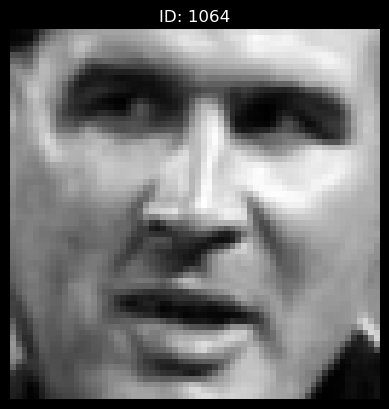

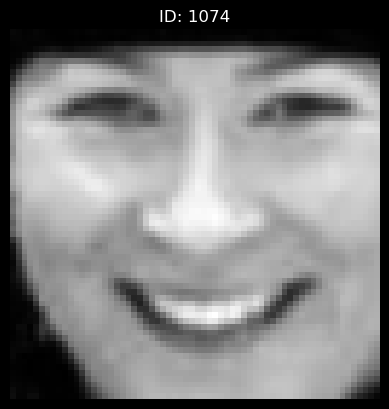

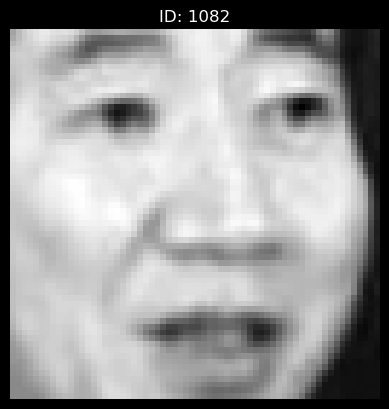

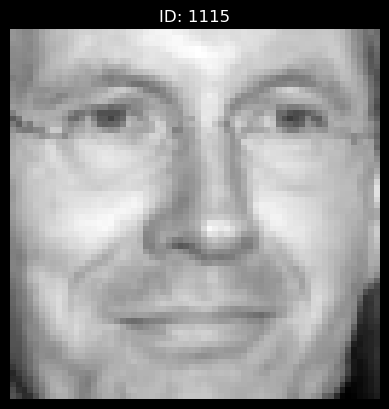

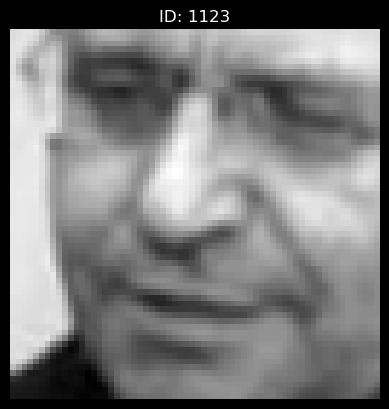

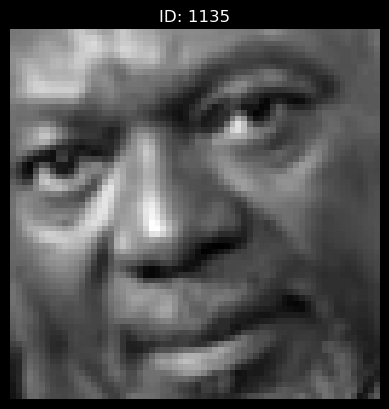

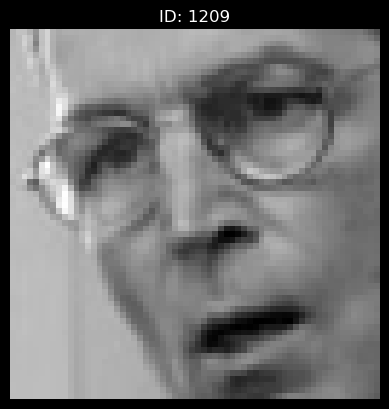

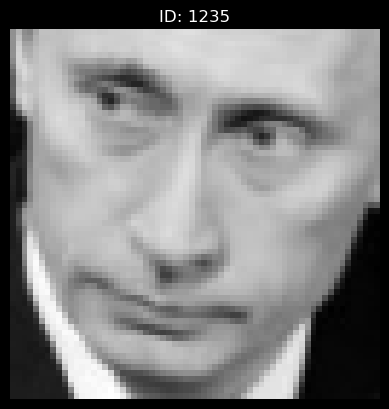

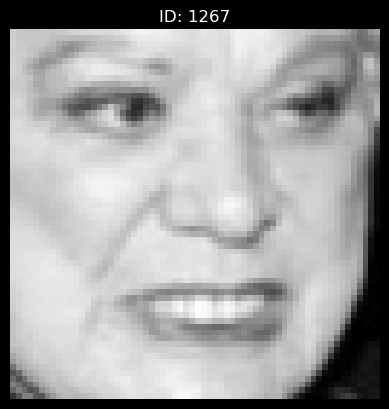

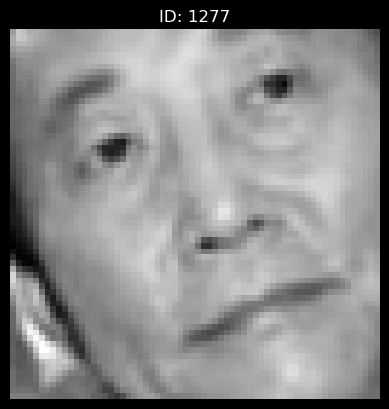

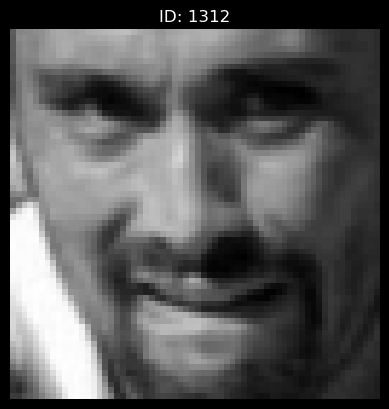

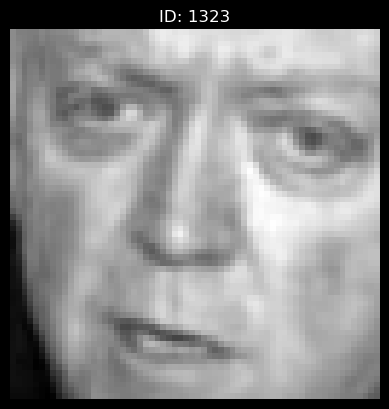

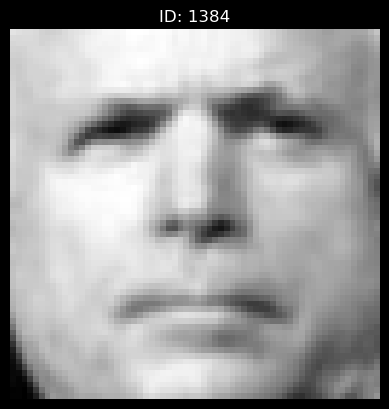

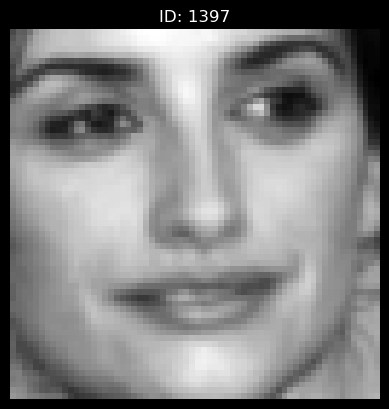

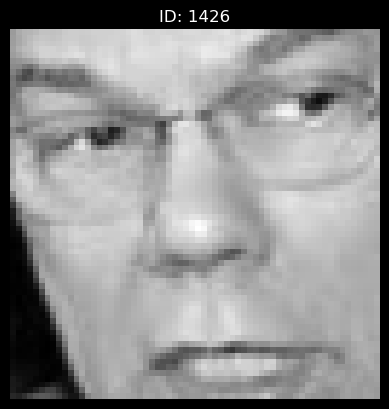

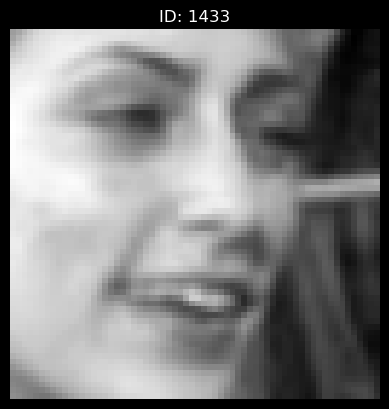

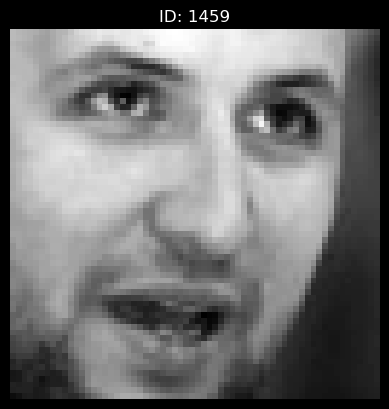

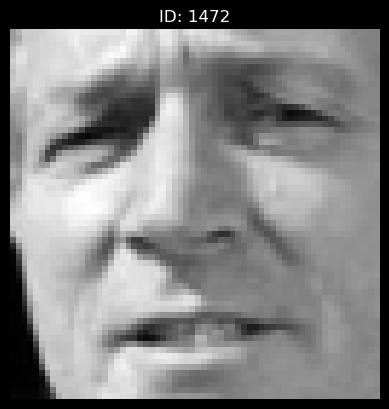

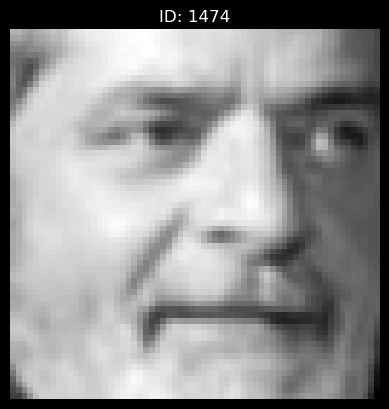

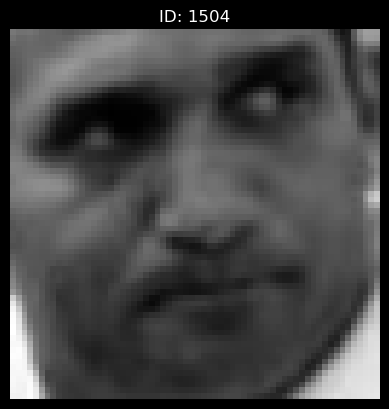

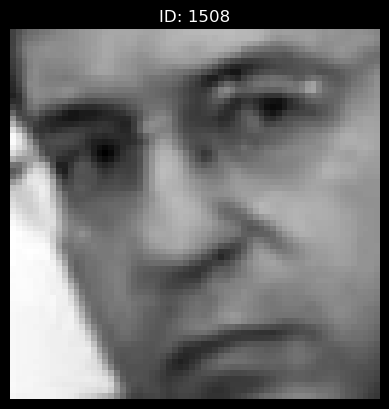

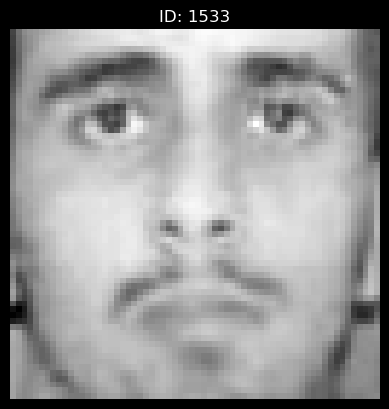

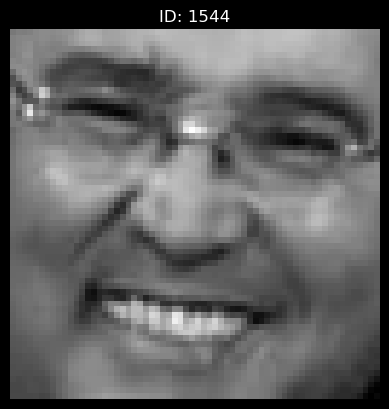

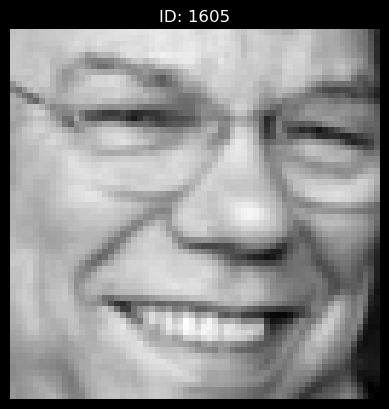

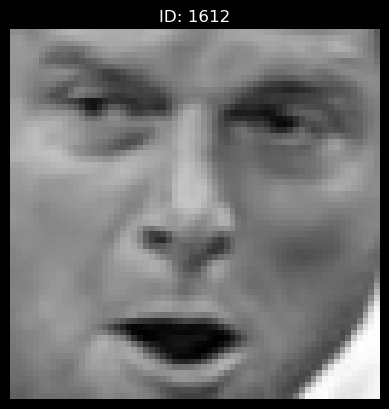

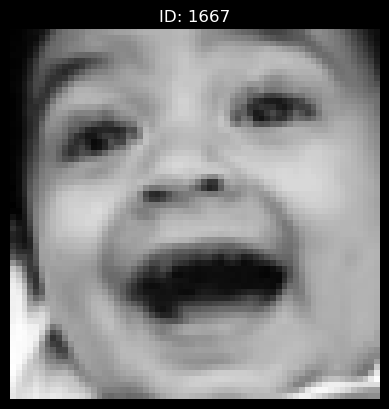

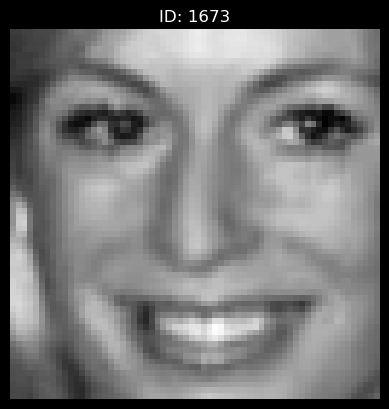

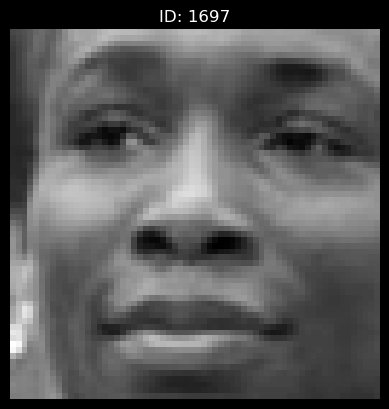

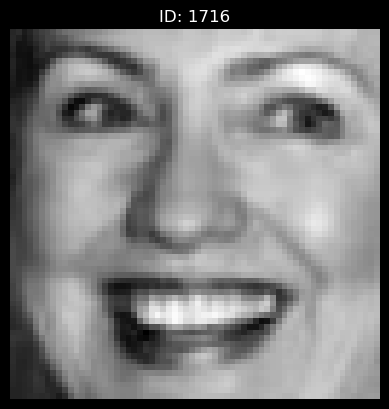

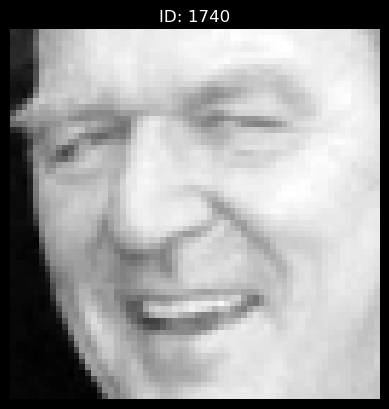

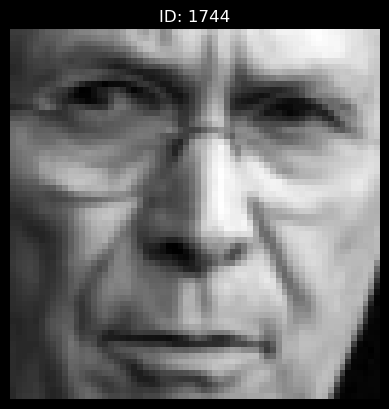

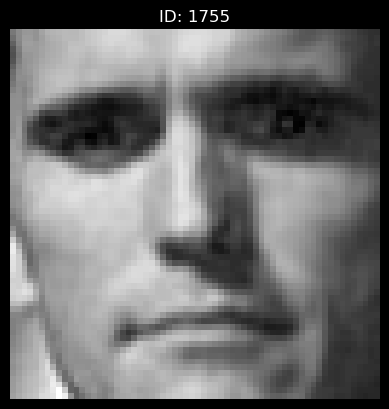

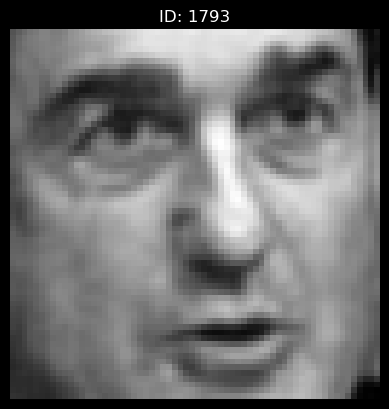

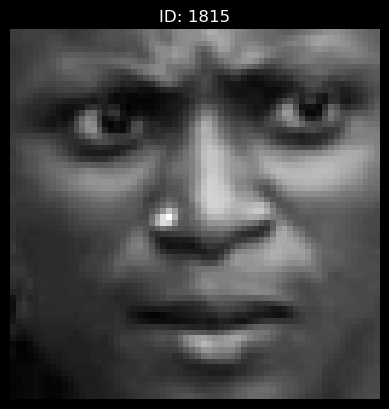

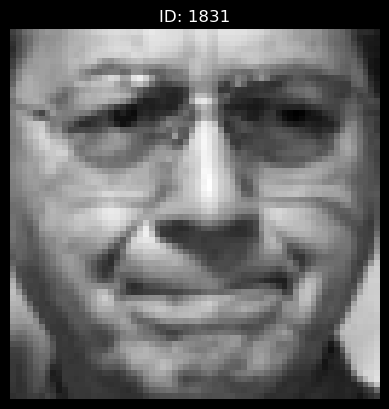

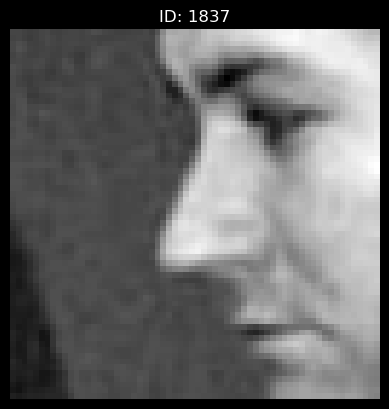

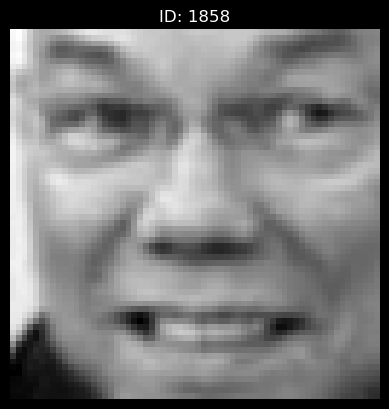

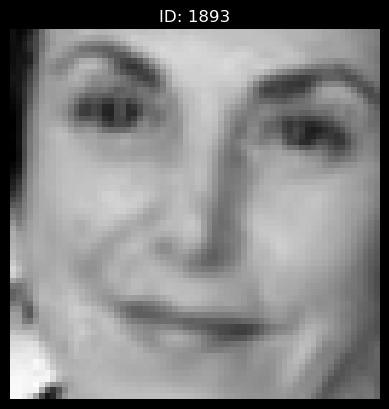

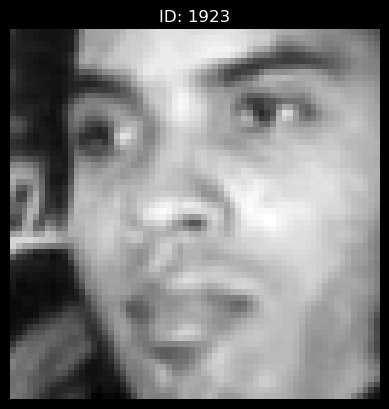

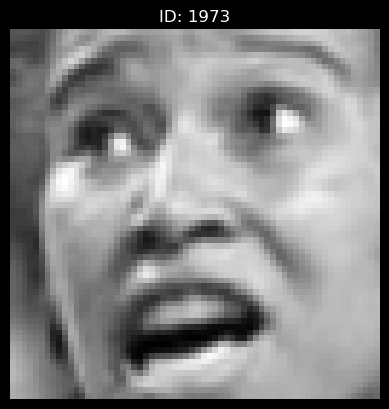

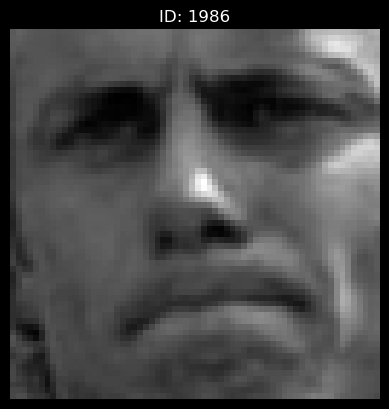

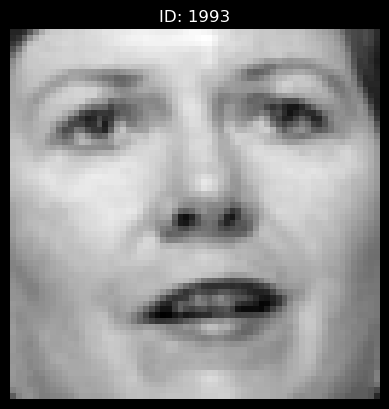

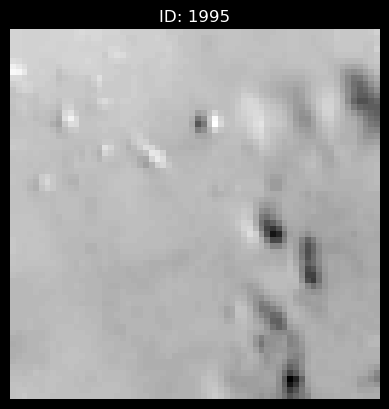

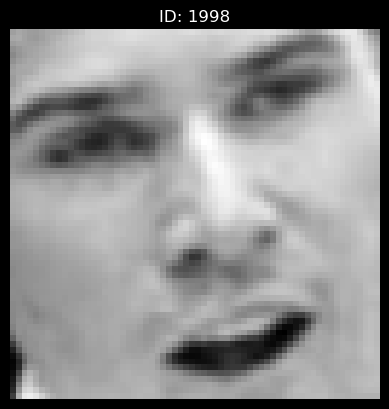

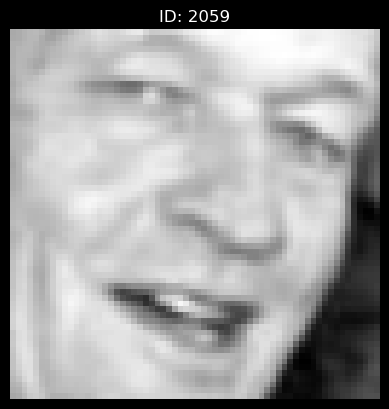

In [44]:
# Mostrar únicamente las 30 primeras imágenes de kaggle_patches cuya predicción es 1
for idx in indices_positivos[0:150]:
    plt.imshow(kaggle_patches[idx], cmap='gray')
    plt.title(f"ID: {kaggle_hat.iloc[idx]['id']}")
    plt.axis('off')
    plt.show()


In [45]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'prueba_Lr_v3'  # Cambiar el nombre del archivo según sea necesario
kaggle_hat.to_csv('../submissions/'+ submission_name + '.csv', index=False)